## Before creating this notebbok i referred openfda website for, how to build a api end point to fetch the data and i saw some results using UI given in the website,and it helped a lot to understand the data

# importing Necessary Libraries

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import json
import requests
import time
import itertools
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Url to fetch data

In [2]:
query_url = """https://api.fda.gov/drug/label.json?search=openfda.manufacturer_name:%22AstraZeneca%22&limit=37"""
response = requests.get(query_url).json()
# data = pd.DataFrame(data.get('results'))

In [3]:
def extract_relevant_data(r):
    l = []
    for i in r['results']:
        effective_time = int(i['effective_time'][:-4])

        if i['openfda'] == {}:
            continue
        manufacturer_name = i['openfda']['manufacturer_name']

        # handle situation when the route key is not present
        try:
            route = i['openfda']['route']
            if isinstance(route, list) and len(route) == 1:
                route = route[0]
        except KeyError:
            route = np.nan
        generic_name = i['openfda']['generic_name']
        spl_product_data_elements = len(i['spl_product_data_elements'][0].split(','))

        l.append([generic_name, route, effective_time, spl_product_data_elements, manufacturer_name])
    return pd.DataFrame(l, columns=['generic_name', 'route', 'year', 'num_ingredients', 'manufacturer'])

## calling the function to retrive the necessary features 

In [4]:
data = extract_relevant_data(response)
data.head()

,generic_name,route,year,num_ingredients,manufacturer
0,[QUETIAPINE],ORAL,2020,19,[AstraZeneca Pharmaceuticals LP]
1,[FULVESTRANT],INTRAMUSCULAR,2019,1,[AstraZeneca Pharmaceuticals LP]
2,[BUDESONIDE AND FORMOTEROL FUMARATE DIHYDRATE],RESPIRATORY (INHALATION),2019,1,[AstraZeneca Pharmaceuticals LP]
3,[EXENATIDE],SUBCUTANEOUS,2020,7,[AstraZeneca Pharmaceuticals LP]
4,[BUDESONIDE],RESPIRATORY (INHALATION),2019,4,[AstraZeneca Pharmaceuticals LP]


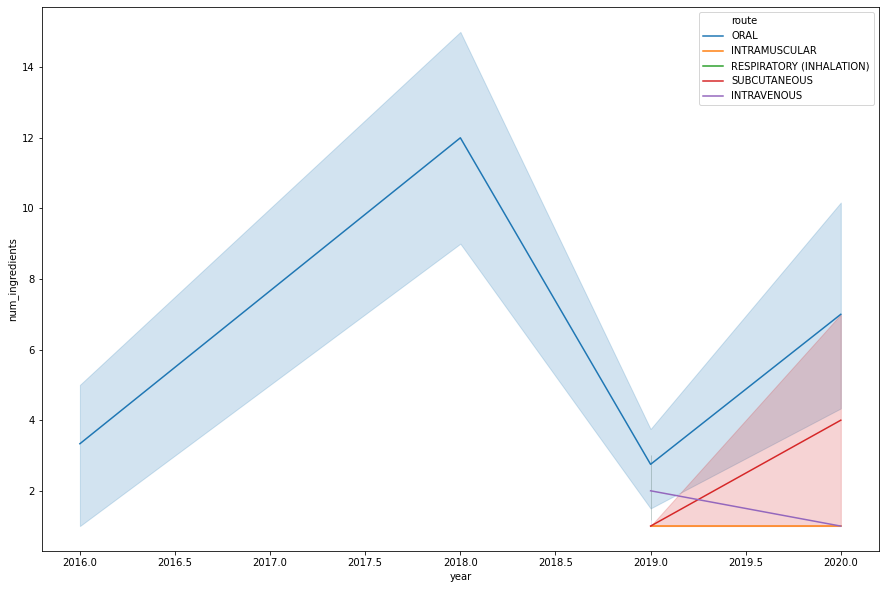

In [9]:
rcParams["figure.figsize"] = 15,10
sns.lineplot(x=data["year"],y=data["num_ingredients"],hue=data["route"])

 ## Calculates the average number of ingredients in AstraZeneca products per year

In [11]:
names = {}
for label, df in data.groupby(by='year'):
    n = df[df['year'] == label]['generic_name'].values
    names[label] = [''.join(i for i in itertools.chain(*n))]
drug_names_df = pd.DataFrame(names).transpose()
mean = data.groupby(by='year').mean()
df = mean.merge(drug_names_df, left_index=True, right_index=True)
df.columns.str.replace('Unnamed: 0','year')
df.columns = ['avg_number_of_ingredients', 'drug_names']
df = df[['drug_names', 'avg_number_of_ingredients']]

In [12]:
df

,drug_names,avg_number_of_ingredients
year,,
2016,CANDESARTAN CILEXETIL AND HYDROCHLOROTHIAZIDEM...,3.333333
2018,ESOMEPRAZOLE MAGNESIUMESOMEPRAZOLE MAGNESIUM,12.000000
2019,FULVESTRANTBUDESONIDE AND FORMOTEROL FUMARATE ...,2.000000
2020,QUETIAPINEEXENATIDEDAPAGLIFLOZIN AND SAXAGLIPT...,6.294118


In [13]:
df['year'] = [2016,2017,2019,2020]

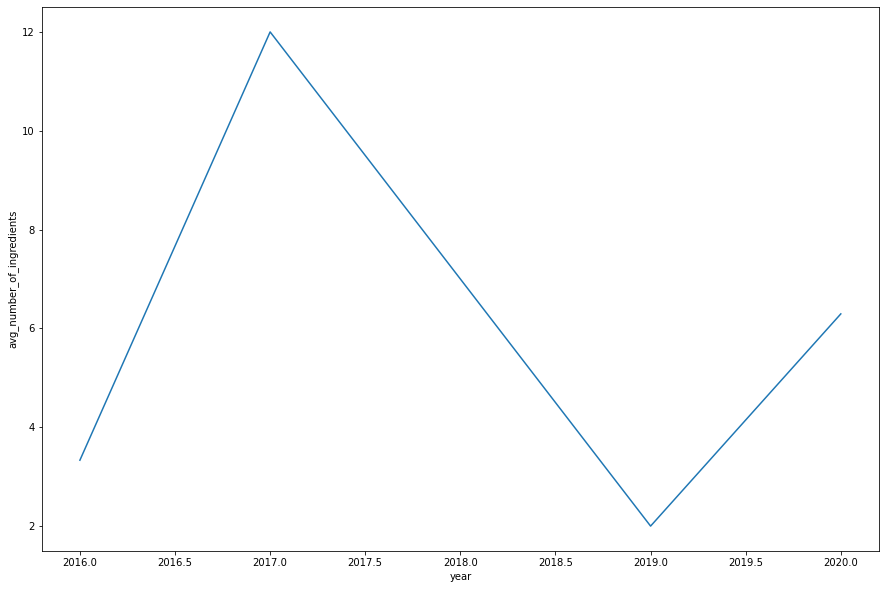

In [15]:
rcParams["figure.figsize"] = 15,10
sns.lineplot(x=df["year"],y=df["avg_number_of_ingredients"])

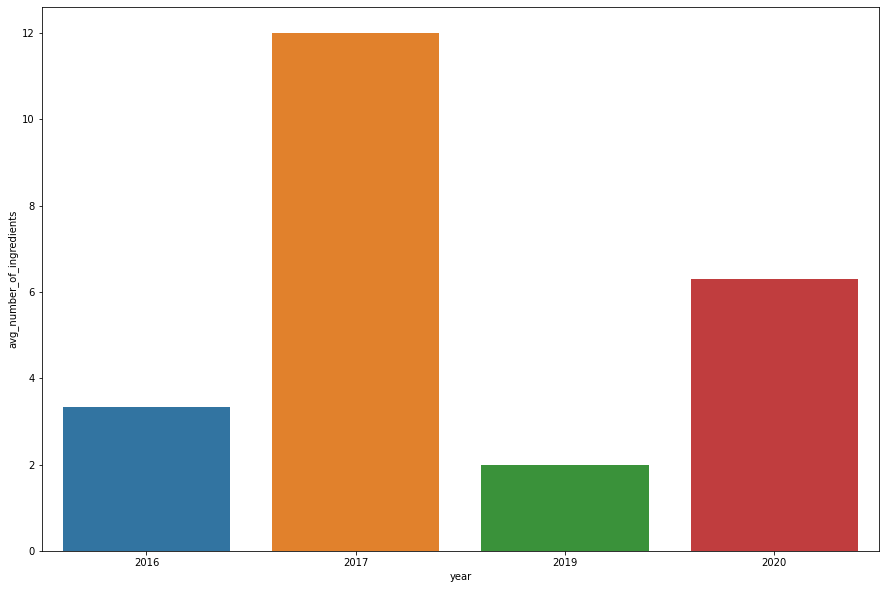

In [16]:
rcParams["figure.figsize"] = 15,10
sns.barplot(x=df["year"],y=df["avg_number_of_ingredients"])

## Calculates the average number of ingredients in AstraZeneca products per year and per method of administration

In [17]:
names = {}
for label, df in data.groupby(by=['year', 'route']):
    n = df[(df['year'] == label[0]) & (df['route'] == label[1])]['generic_name'].values
    names[label] = [''.join([i for i in itertools.chain(*n)])]
drug_names_df = pd.DataFrame(names).transpose()
drug_names_df.index.names = ['year', 'route']
mean = data.groupby(by=['year', 'route']).mean()
drug_names_df.columns = ['drug_name']

df = pd.concat([mean, drug_names_df], axis=1)
df = df[['drug_name', 'num_ingredients']]
df.rename(columns={'num_ingredients': 'avg_number_of_ingredients'}, inplace=True)

In [18]:
df.shape

(11, 2)

In [19]:
df['year'] = [2016,2017,2019,2019,2019,2019,2019,2020,2020,2020,2020]

In [20]:
df.columns

Index(['drug_name', 'avg_number_of_ingredients', 'year'], dtype='object')

In [21]:
oral = ["ORAL","ORAL","INTRAMUSCULAR","INTRAVENOUS","ORAL","RESPIRATORY (INHALATION)","SUBCUTANEOUS","INTRAMUSCULAR","INTRAVENOUS","ORAL","SUBCUTANEOUS"]
df['oral'] = oral

In [22]:
df.reset_index(drop=True, inplace=True)

In [23]:
df

,drug_name,avg_number_of_ingredients,year,oral
0,CANDESARTAN CILEXETIL AND HYDROCHLOROTHIAZIDEM...,3.333333,2016,ORAL
1,ESOMEPRAZOLE MAGNESIUMESOMEPRAZOLE MAGNESIUM,12.000000,2017,ORAL
2,FULVESTRANT,1.000000,2019,INTRAMUSCULAR
3,ESOMEPRAZOLE SODIUMMOXETUMOMAB PASUDOTOX,2.000000,2019,INTRAVENOUS
4,GEFITINIBSAXAGLIPTINACALABRUTINIBSAXAGLIPTIN A...,2.750000,2019,ORAL
5,BUDESONIDE AND FORMOTEROL FUMARATE DIHYDRATEBU...,2.000000,2019,RESPIRATORY (INHALATION)
6,PRAMLINTIDE ACETATEBENRALIZUMAB,1.000000,2019,SUBCUTANEOUS
7,FULVESTRANT,1.000000,2020,INTRAMUSCULAR
8,DURVALUMAB,1.000000,2020,INTRAVENOUS
9,QUETIAPINEDAPAGLIFLOZIN AND SAXAGLIPTINQUETIAP...,7.000000,2020,ORAL


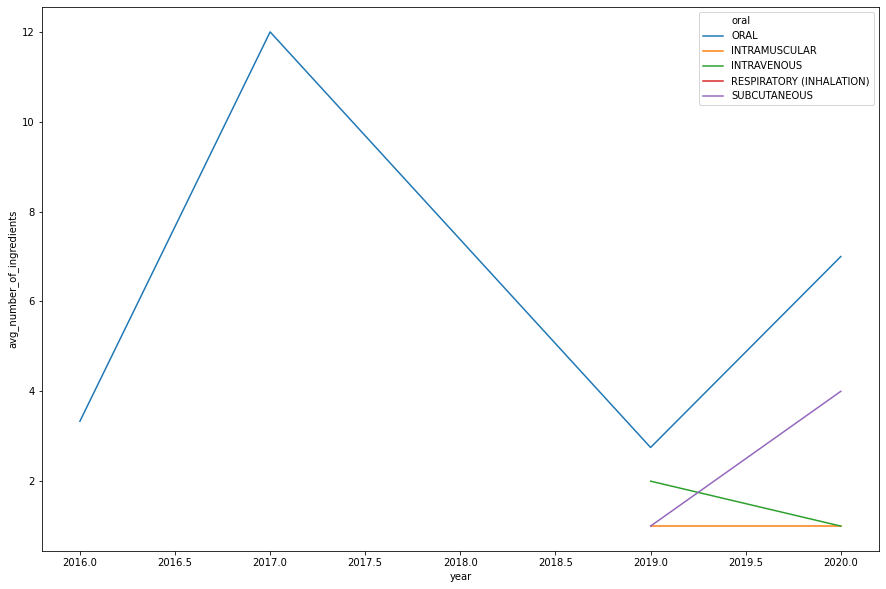

In [24]:
rcParams["figure.figsize"] = 15,10
sns.lineplot(x=df["year"],y=df["avg_number_of_ingredients"],hue=df["oral"])

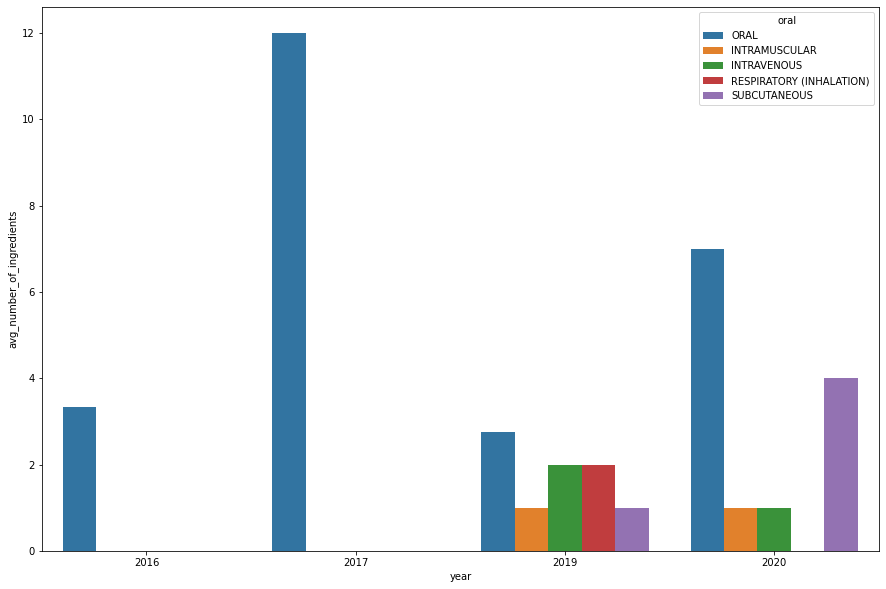

In [25]:
rcParams["figure.figsize"] = 15,10
sns.barplot(x=df["year"],y=df["avg_number_of_ingredients"],hue=df["oral"])